# Coordinate Transformations and Subsetting

**Author:** Michael Needham, US EPA Region 7 Air and Radiation Division

**Contact:** needham.michael@epa.gov

**Description:** Auxiliary example showing how to manage data in different coordinate systems. Makes use of __[cartopy](https://scitools.org.uk/cartopy/docs/latest/)__ for coordinate reference systems, as well as __[geopandas](https://geopandas.org/en/stable/)__ and __[shapely](https://shapely.readthedocs.io/en/stable/manual.html)__ to manage points and polygons across coordinate systems.

In [1]:
import shapely
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import xarray as xr

ERROR 1: PROJ: proj_create_from_database: Open of /work/REGIONS/users/mneedham/.miniforge3/envs/cmaq_pyenv/share/proj failed


In [2]:
from src.utils.cmaq import get_cmaq_projection, get_cmaq_metadata

## 1. Conversion of a ordered pairs

Demonstrate how to convert an ordered in one coordinate system to a separate system. Start with a __[plate carree](https://en.wikipedia.org/wiki/Equirectangular_projection)__ (latitude/longitude) projection and convert to a __[Lambert conformal conic](https://en.wikipedia.org/wiki/Lambert_conformal_conic_projection)__ projection (commonly used for CMAQ modeling).

Coordinate transformations are trivial using __[geopandas.GeoDataFrame.to_crs](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.to_crs.html)__ as long as the initial coordinate reference system is defined.

In [3]:
def add_features(ax,scale="110m"):
    """Add basic reference features to a cartopy geoaxis"""
    ax.add_feature(cfeature.LAKES.with_scale(scale))
    ax.add_feature(cfeature.LAND.with_scale(scale))
    ax.add_feature(cfeature.OCEAN.with_scale(scale))
    ax.add_feature(cfeature.BORDERS.with_scale(scale))
    ax.add_feature(cfeature.STATES.with_scale(scale))
    ax.coastlines()

In [4]:
# specify initial and final projections

proj_i = ccrs.PlateCarree()

proj_f = ccrs.LambertConformal(
    central_longitude=-97.0,
    central_latitude=40.0,
    false_easting=2952000.0,
    false_northing=2772000.0,
    standard_parallels=[33.0,45.0]
)

# specify points for transformation
cities = {
    "New York City" : shapely.Point(-74.006,40.713), # 
    "Chicago"       : shapely.Point(-87.630,41.878), # 
    "Miami"         : shapely.Point(-80.192,25.762), # 
    "Denver"        : shapely.Point(-104.990,39.739), # 
    "Seattle"       : shapely.Point(-122.333,47.606), # 
    "San Francisco" : shapely.Point(-122.419,37.775), # 
}

cities_i = gpd.GeoDataFrame(
    {'cities':list(cities.keys())},
    geometry=list(cities.values()),
    crs=ccrs.PlateCarree()
)

cities_f = cities_i.to_crs(proj_f)

In [5]:
# Printout the coordinates

print("="*60)
print("Latitude / Longitude Coordinates")
print("-"*60)
print(cities_i)
print("\n")

print("="*60)
print("Lambert Conformal Conic Coordinates")
print("-"*60)
print(cities_f)

Latitude / Longitude Coordinates
------------------------------------------------------------
          cities                 geometry
0  New York City   POINT (-74.006 40.713)
1        Chicago   POINT (-87.630 41.878)
2          Miami   POINT (-80.192 25.762)
3         Denver  POINT (-104.990 39.739)
4        Seattle  POINT (-122.333 47.606)
5  San Francisco  POINT (-122.419 37.775)


Lambert Conformal Conic Coordinates
------------------------------------------------------------
          cities                         geometry
0  New York City  POINT (4864581.795 3094031.125)
1        Chicago  POINT (3725101.887 3019429.266)
2          Miami  POINT (4662682.581 1347434.957)
3         Denver  POINT (2271685.452 2773103.355)
4        Seattle  POINT (1060281.897 3881461.866)
5  San Francisco   POINT (753169.968 2835872.794)


<GeoAxes: title={'left': 'Lambert Projection'}>

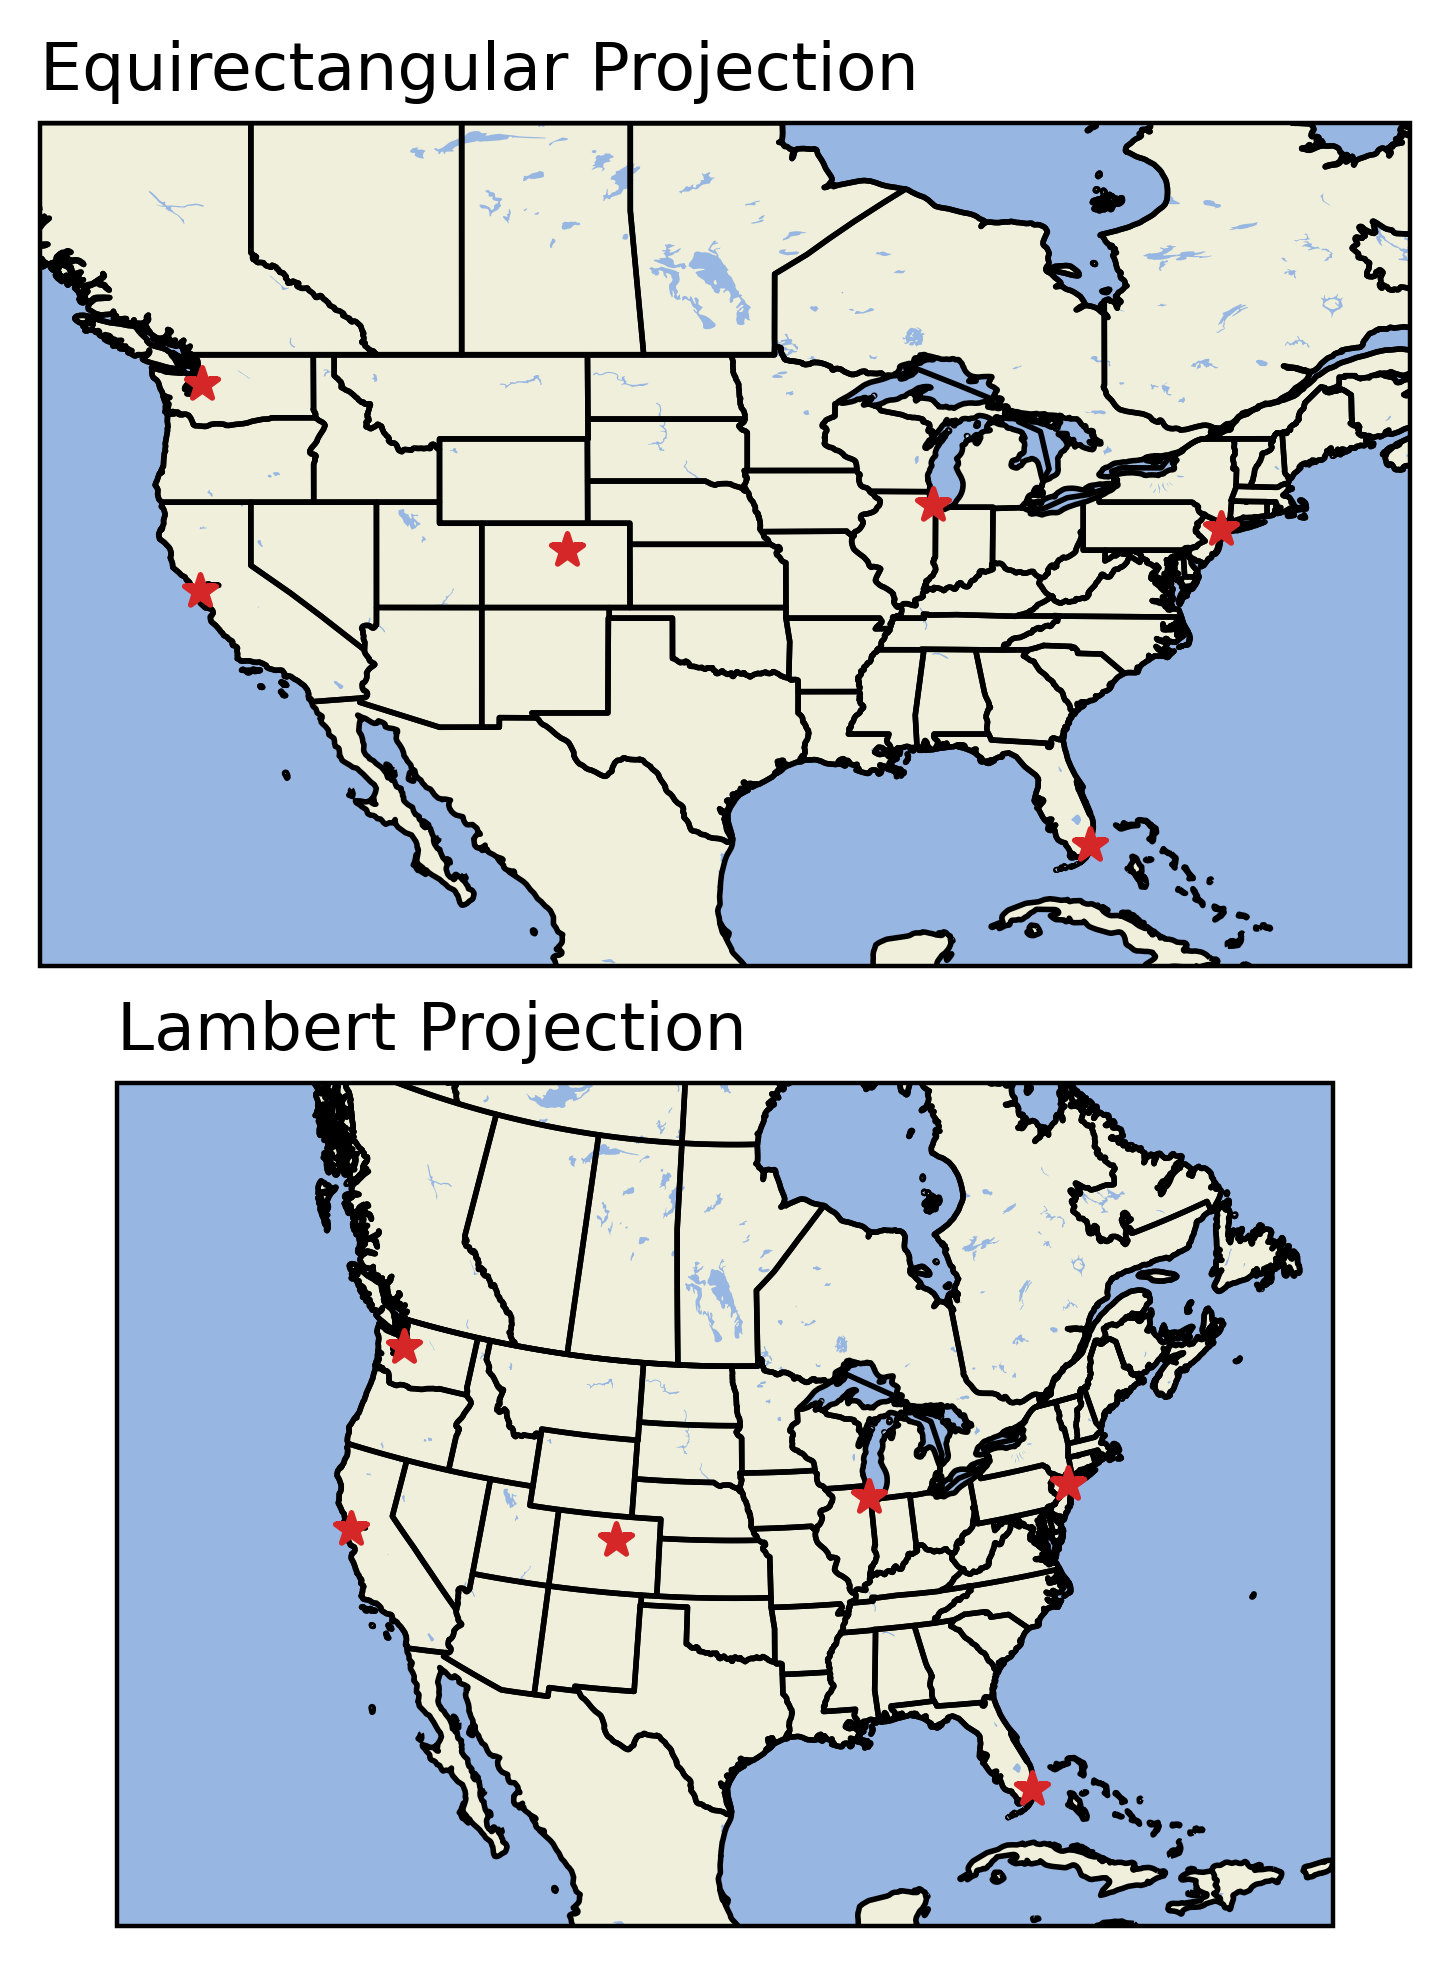

In [6]:
fig = plt.figure(dpi=400,layout='constrained')

ax1 = fig.add_subplot(211,projection=proj_i)
ax2 = fig.add_subplot(212,projection=proj_f)

ax1.set_extent([-130,-65,20,60],crs=ccrs.PlateCarree())
ax2.set_extent([-130,-65,20,60],crs=ccrs.PlateCarree())

ax1.set_title("Equirectangular Projection",loc='left')
ax2.set_title("Lambert Projection",loc='left')

scale = "50m"

add_features(ax1,scale)
add_features(ax2,scale)

cities_i.plot(ax=ax1,color='tab:red',marker='*',zorder=10)
cities_f.plot(ax=ax2,color='tab:red',marker='*',zorder=10)

## 2. Conversion of arbitrary shapes

The same process works for any other type of __[shapely.Geometry](https://shapely.readthedocs.io/en/stable/geometry.html)__ such as a __[shapely.Polygon](https://shapely.readthedocs.io/en/stable/reference/shapely.Polygon.html#shapely.Polygon)__. 

<div class="alert alert-block alert-warning">
Shapely features are drawn with straight lines on the projected coordinate system (that is, points are connected by the curve which minimizes the euclidean distance in the projected coordinate syatem; they do not minimize the geodesic distance). Instead, the shortest distance is a segment of a <b><a href=https://en.wikipedia.org/wiki/Great_circle>great circle</a></b> (if the Earth is treated as a sphere), or of a <b><a href=https://en.wikipedia.org/wiki/Geodesics_on_an_ellipsoide>geodesic on an ellipsoid</a></b> (if the earth is treated as an *oblete ellipsoid). For most applications, this distinction should not matter, but it may arise in certain circumstances.
</div>

In [17]:
texas_triangle = {
    "Dallas"  : shapely.Point(-96.797,32.776),
    "Houston" : shapely.Point(-95.370,29.760),
    "San Antonio" : shapely.Point(-98.495,29.425)
}

texas_triangle['Region'] = shapely.Polygon(
    shell = [texas_triangle['Dallas'],texas_triangle['Houston'],texas_triangle['San Antonio']]
)

shapes_i = gpd.GeoDataFrame(
    {'regions':list(texas_triangle.keys())},
    geometry=list(texas_triangle.values()),
    crs=ccrs.PlateCarree()
)

shapes_f = shapes_i.to_crs(proj_f)

shapes_i

,regions,geometry
0,Dallas,POINT (-96.797 32.776)
1,Houston,POINT (-95.370 29.760)
2,San Antonio,POINT (-98.495 29.425)
3,Region,"POLYGON ((-96.797 32.776, -95.370 29.760, -98...."


<GeoAxes: title={'left': 'Lambert Projection'}>

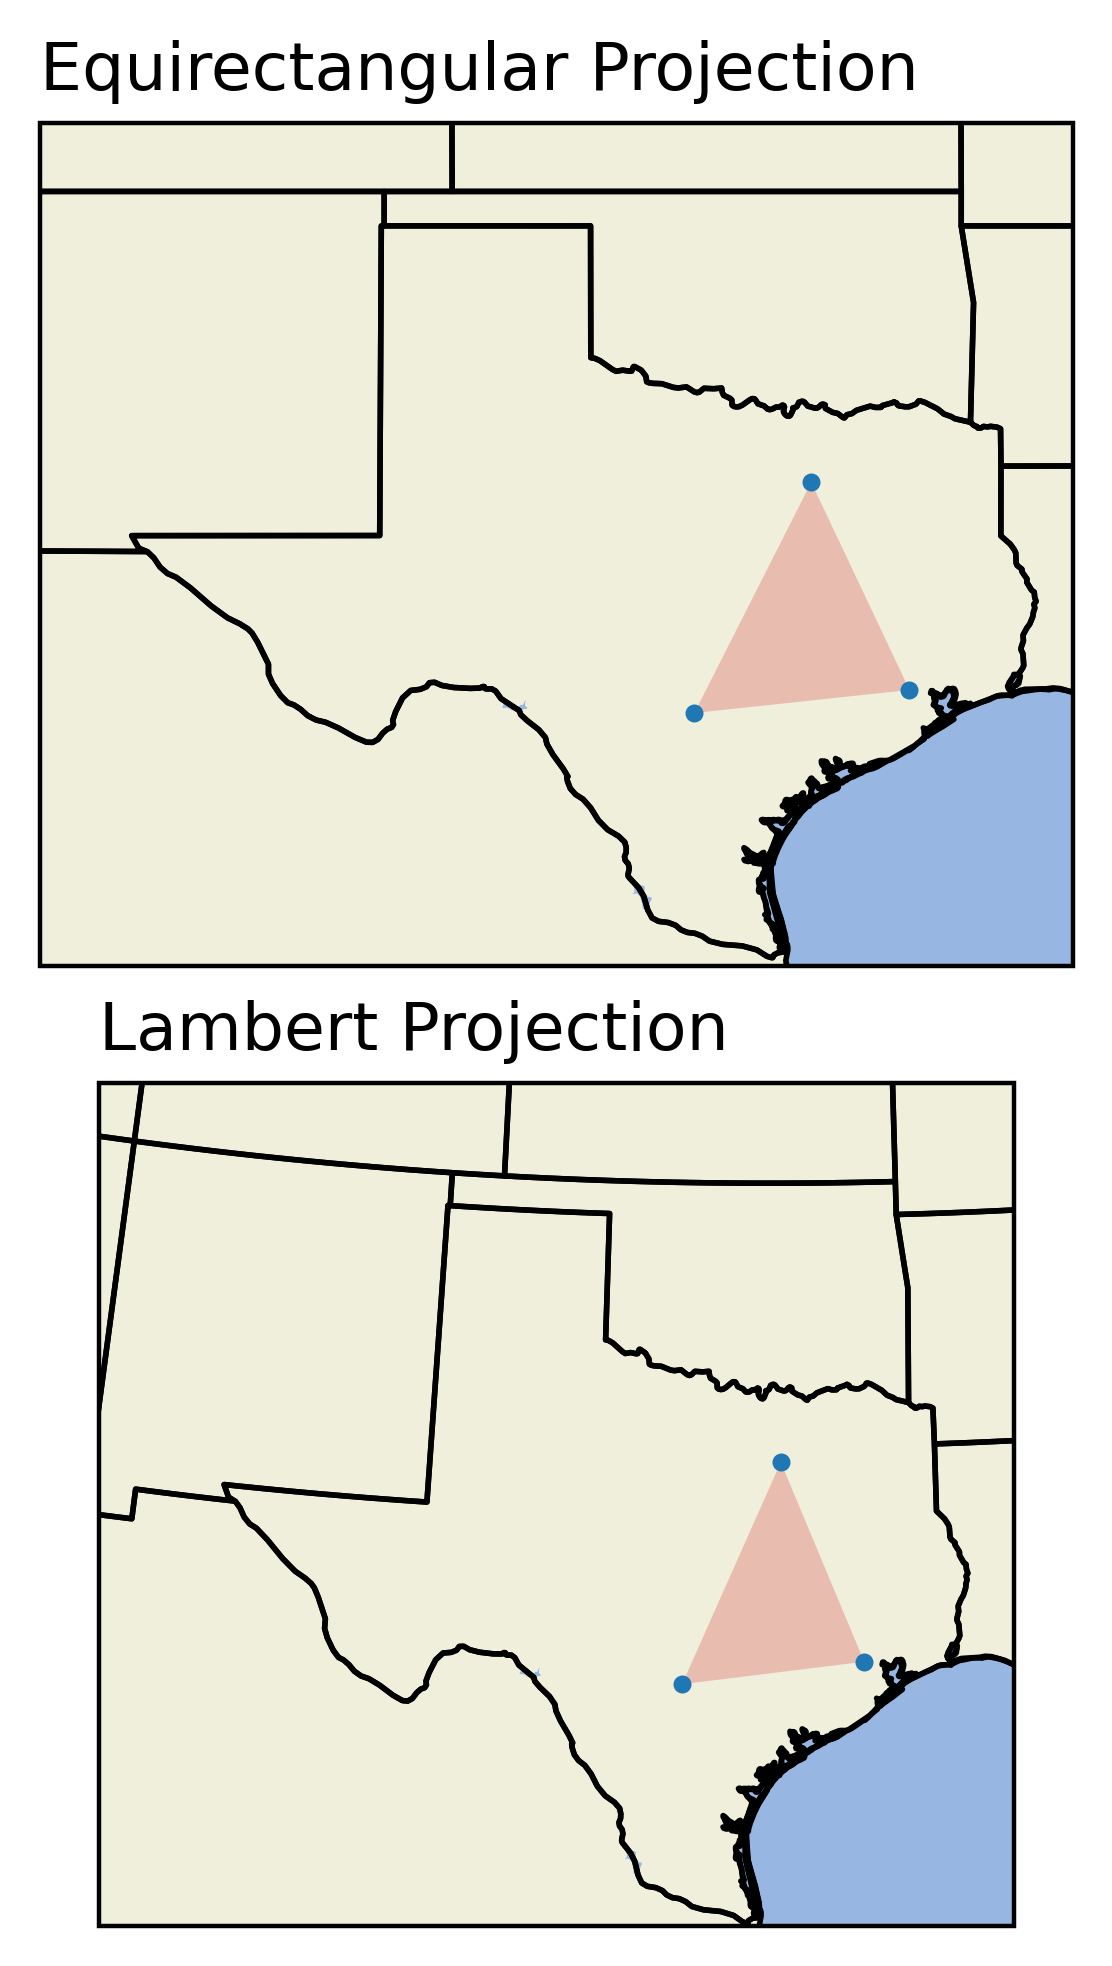

In [9]:
fig = plt.figure(dpi=400,layout='constrained')

ax1 = fig.add_subplot(211,projection=proj_i)
ax2 = fig.add_subplot(212,projection=proj_f)

ax1.set_extent([-108,-93,25.75,38],crs=ccrs.PlateCarree())
ax2.set_extent([-108,-93,25.75,38],crs=ccrs.PlateCarree())

ax1.set_title("Equirectangular Projection",loc='left')
ax2.set_title("Lambert Projection",loc='left')

scale = "50m"

add_features(ax1,scale)
add_features(ax2,scale)

shapes_i.iloc[3:].plot(ax=ax1,color='tab:red',alpha=0.25)
shapes_i.iloc[:3].plot(ax=ax1,color='tab:blue',markersize=5)

shapes_f.iloc[3:].plot(ax=ax2,color='tab:red',alpha=0.25)
shapes_f.iloc[:3].plot(ax=ax2,color='tab:blue',markersize=5)

### 2.1 Application: Bounding Box Subsetting

One obvious application of these transformations is to ease with data subsetting. As an example, CMAQ output data is typically stored in the native Lambert conformal projection, while users typically have defined regions of interest in terms of latitude and longitude coordinates. In this example, we will generate a rectangle in latitude / longitude coordinates, transform it to Lambert coordinates, and use that rectangle to subset CMAQ data.

In [10]:
dset = xr.open_dataset("./tutorial_data/DDM_2022_36US3.011.HR2DAY.2022120-2022217.nc")

proj = get_cmaq_projection(dset)

In [19]:
# Latitude and Longitude coordinates of desired bounding box
x0 = -93
y0 = 36.125
x1 = -87
y1 = 40.5

bbox = {'bounding box':shapely.Polygon(shell=[
    (x0,y0),(x0,y1),(x1,y1),(x1,y0),(x0,y0)
])}

bbox_i = gpd.GeoDataFrame(
    geometry=list(bbox.values()),
    crs=proj_i
)

bbox_f = bbox_i.to_crs(proj_f)

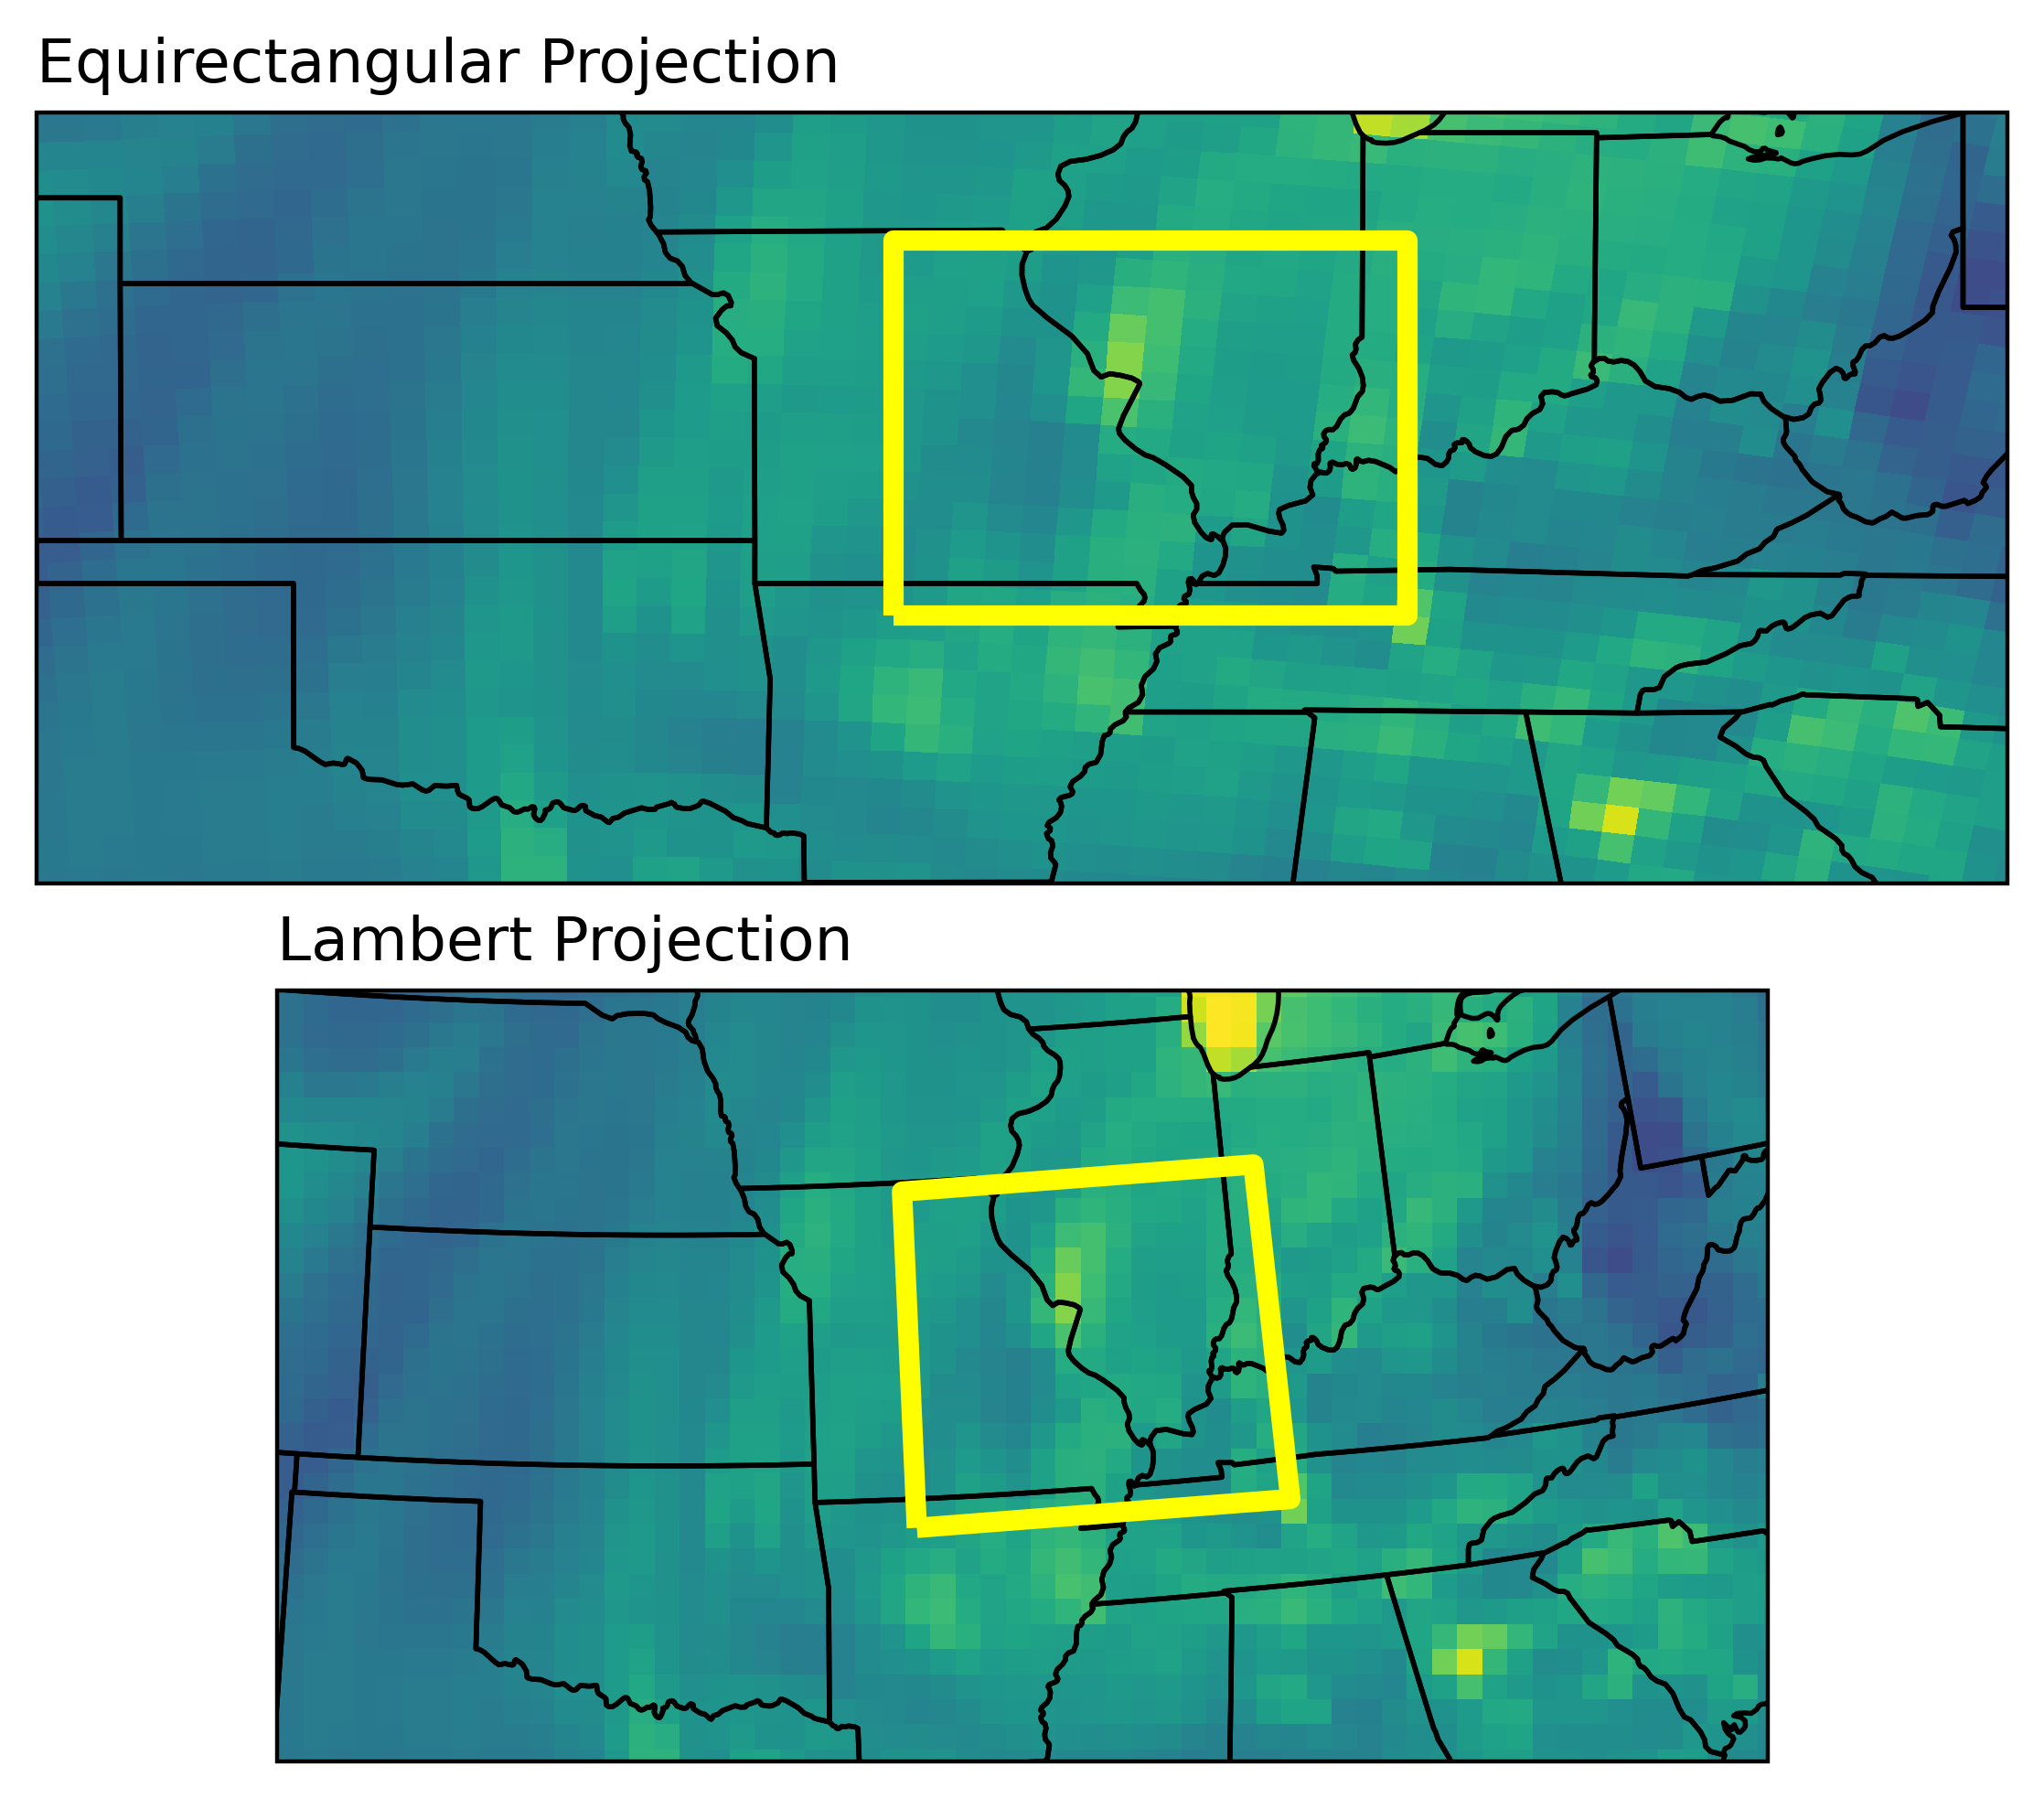

In [21]:
fig = plt.figure(dpi=400,layout='constrained')

ax1 = fig.add_subplot(211,projection=proj_i)
ax2 = fig.add_subplot(212,projection=proj_f)

ax1.set_title("Equirectangular Projection",loc='left')
ax2.set_title("Lambert Projection",loc='left')

for ax in [ax1,ax2]:

    bbox_f.plot(ax=ax,edgecolor='yellow',color='none',lw=4,zorder=10,transform=bbox_f.crs)
    ax.set_extent([-103,-80,33,42],crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.STATES.with_scale(scale))
    ax.pcolormesh(dset.x,dset.y,dset['O3'].isel(time=50),transform=proj)
    
    
    
    


Our rectangle has been transformed to the Lambert coordinates, but note that it is not aligned with the axes. For some applications (e.g., adding a rectangle for the purposes of *displaying* a region of interest) this may be fine. But for our subsetting application, we will want our rectangle aligned with the coordinate axes so that we can pull out a rectangular subset of the data. This can be accomplished with the use of __[shapely.envelope](https://shapely.readthedocs.io/en/maint-2.0/reference/shapely.envelope.html)__ to draw a rectangle in Lambert coordinates that is parallel to the lambert axes **and which fully encompases the rectangle in Lat/Lon coordinates.**

In [22]:
bbox_f_envelope = shapely.envelope(bbox_f)
bbox_f_envelope.crs = bbox_f.crs

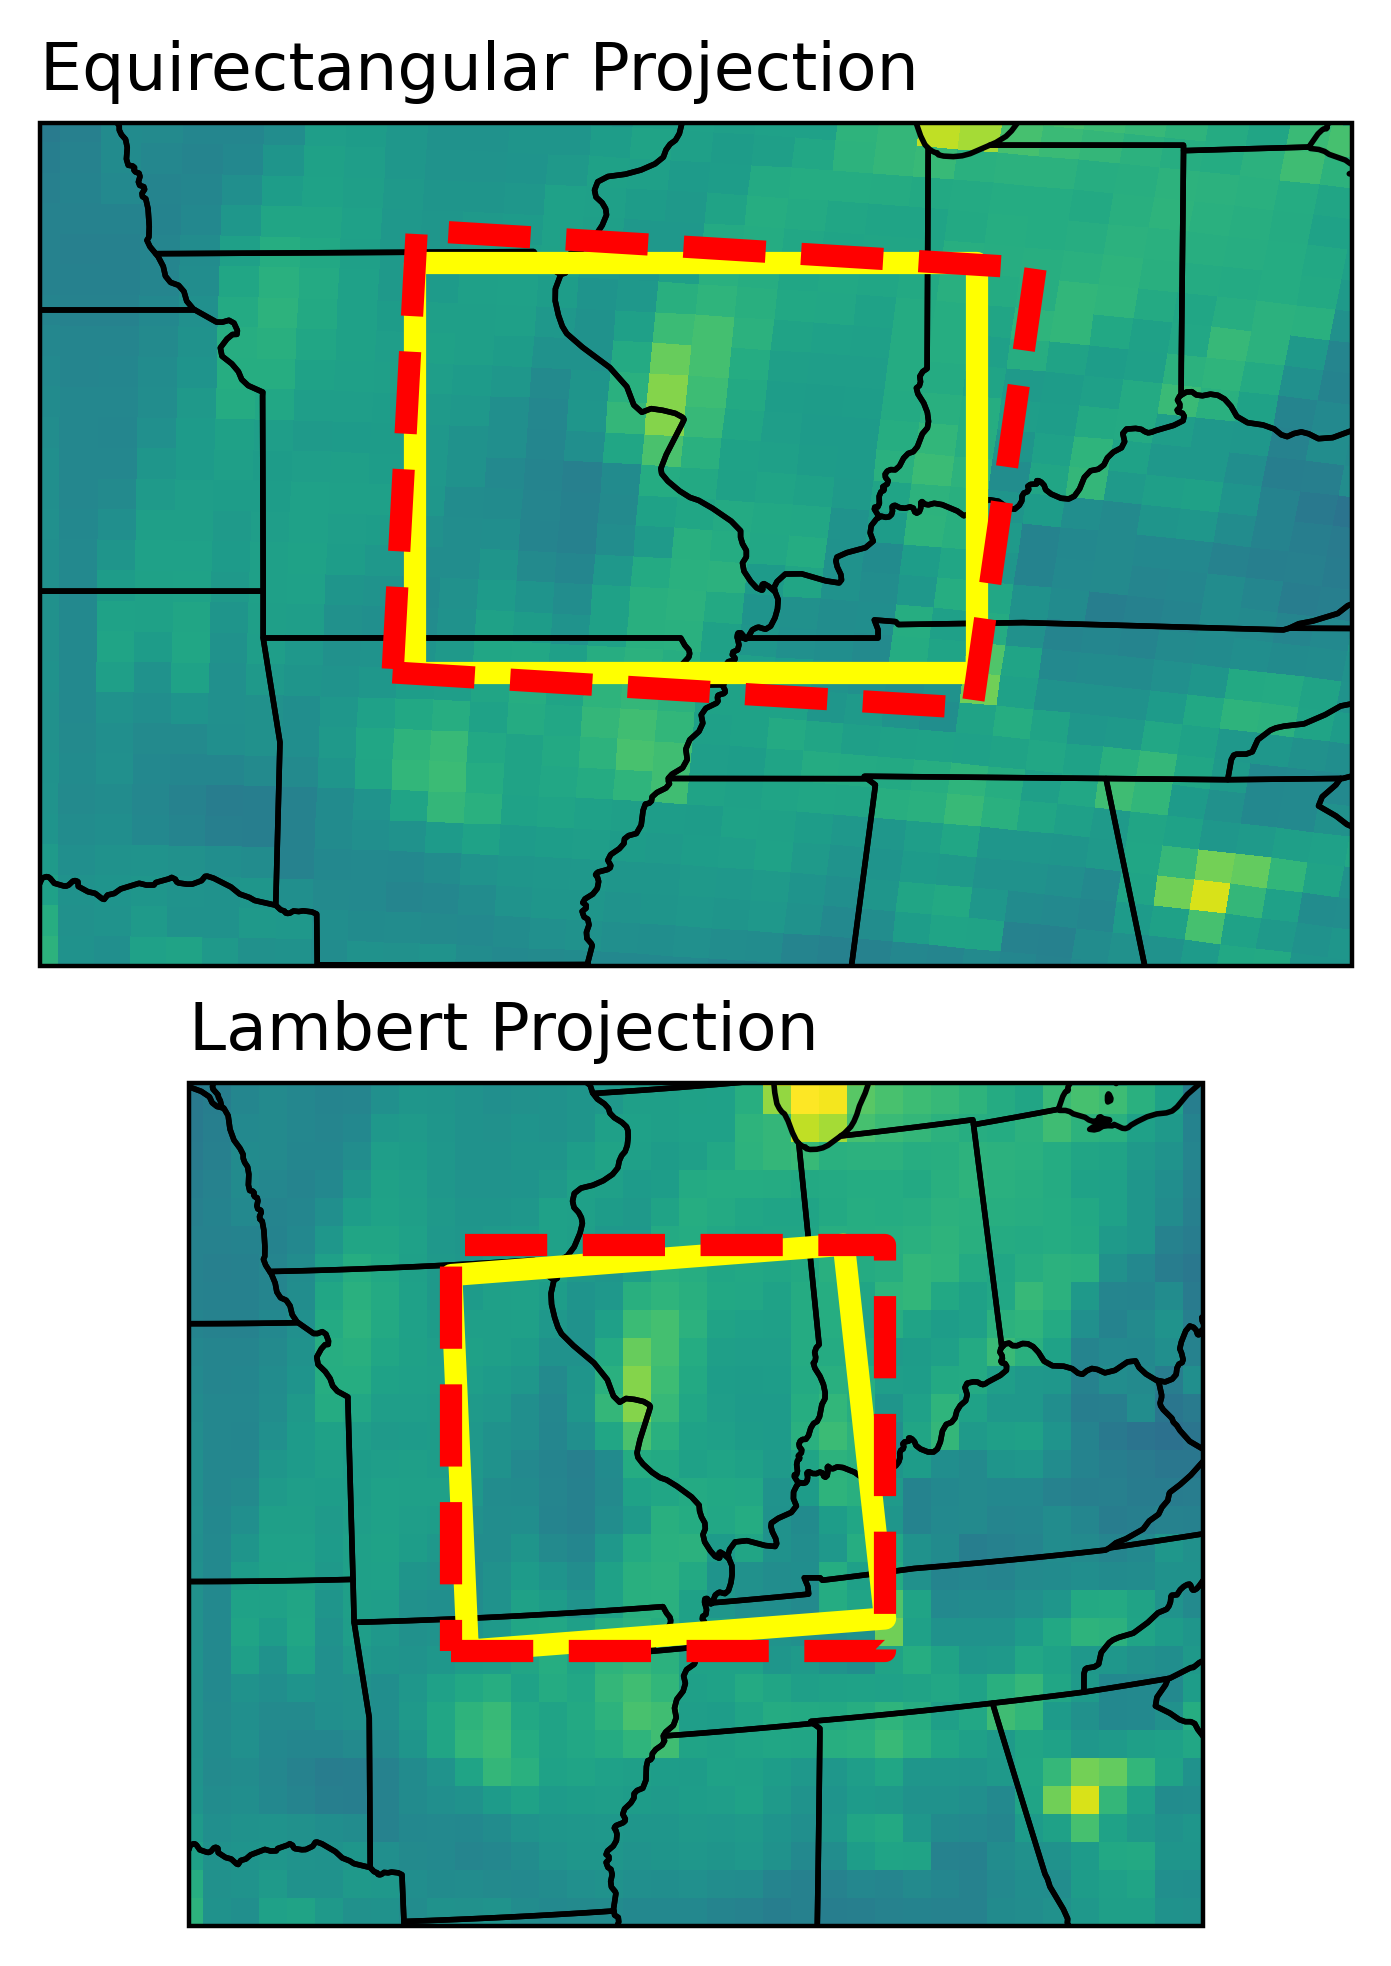

In [23]:
fig = plt.figure(dpi=400,layout='constrained')

ax1 = fig.add_subplot(211,projection=proj_i)
ax2 = fig.add_subplot(212,projection=proj_f)

ax1.set_title("Equirectangular Projection",loc='left')
ax2.set_title("Lambert Projection",loc='left')

for ax in [ax1,ax2]:

    bbox_f.plot(ax=ax,edgecolor='yellow',color='none',lw=4,zorder=10,transform=bbox_f.crs)
    ax.set_extent([-97,-83,33,42],crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.STATES.with_scale(scale))
    ax.pcolormesh(dset.x,dset.y,dset['O3'].isel(time=50),transform=proj)
    
    bbox_f_envelope.plot(ax=ax,edgecolor='r',color='none',lw=4,zorder=10,ls='--',transform=bbox_f_envelope.crs)

Then, we can extract the edges of this new (properly oriented) rectangle to get the x and y limits of our bounding box in Lambert coordinates

In [24]:
coords = bbox_f_envelope.geometry.iloc[0].boundary.coords.xy

xA = coords[0][0]
xB = coords[0][1]

yA = coords[1][0]
yB = coords[1][2]

dset_stl = dset.sel(x=slice(xA,xB),y=slice(yA,yB))    

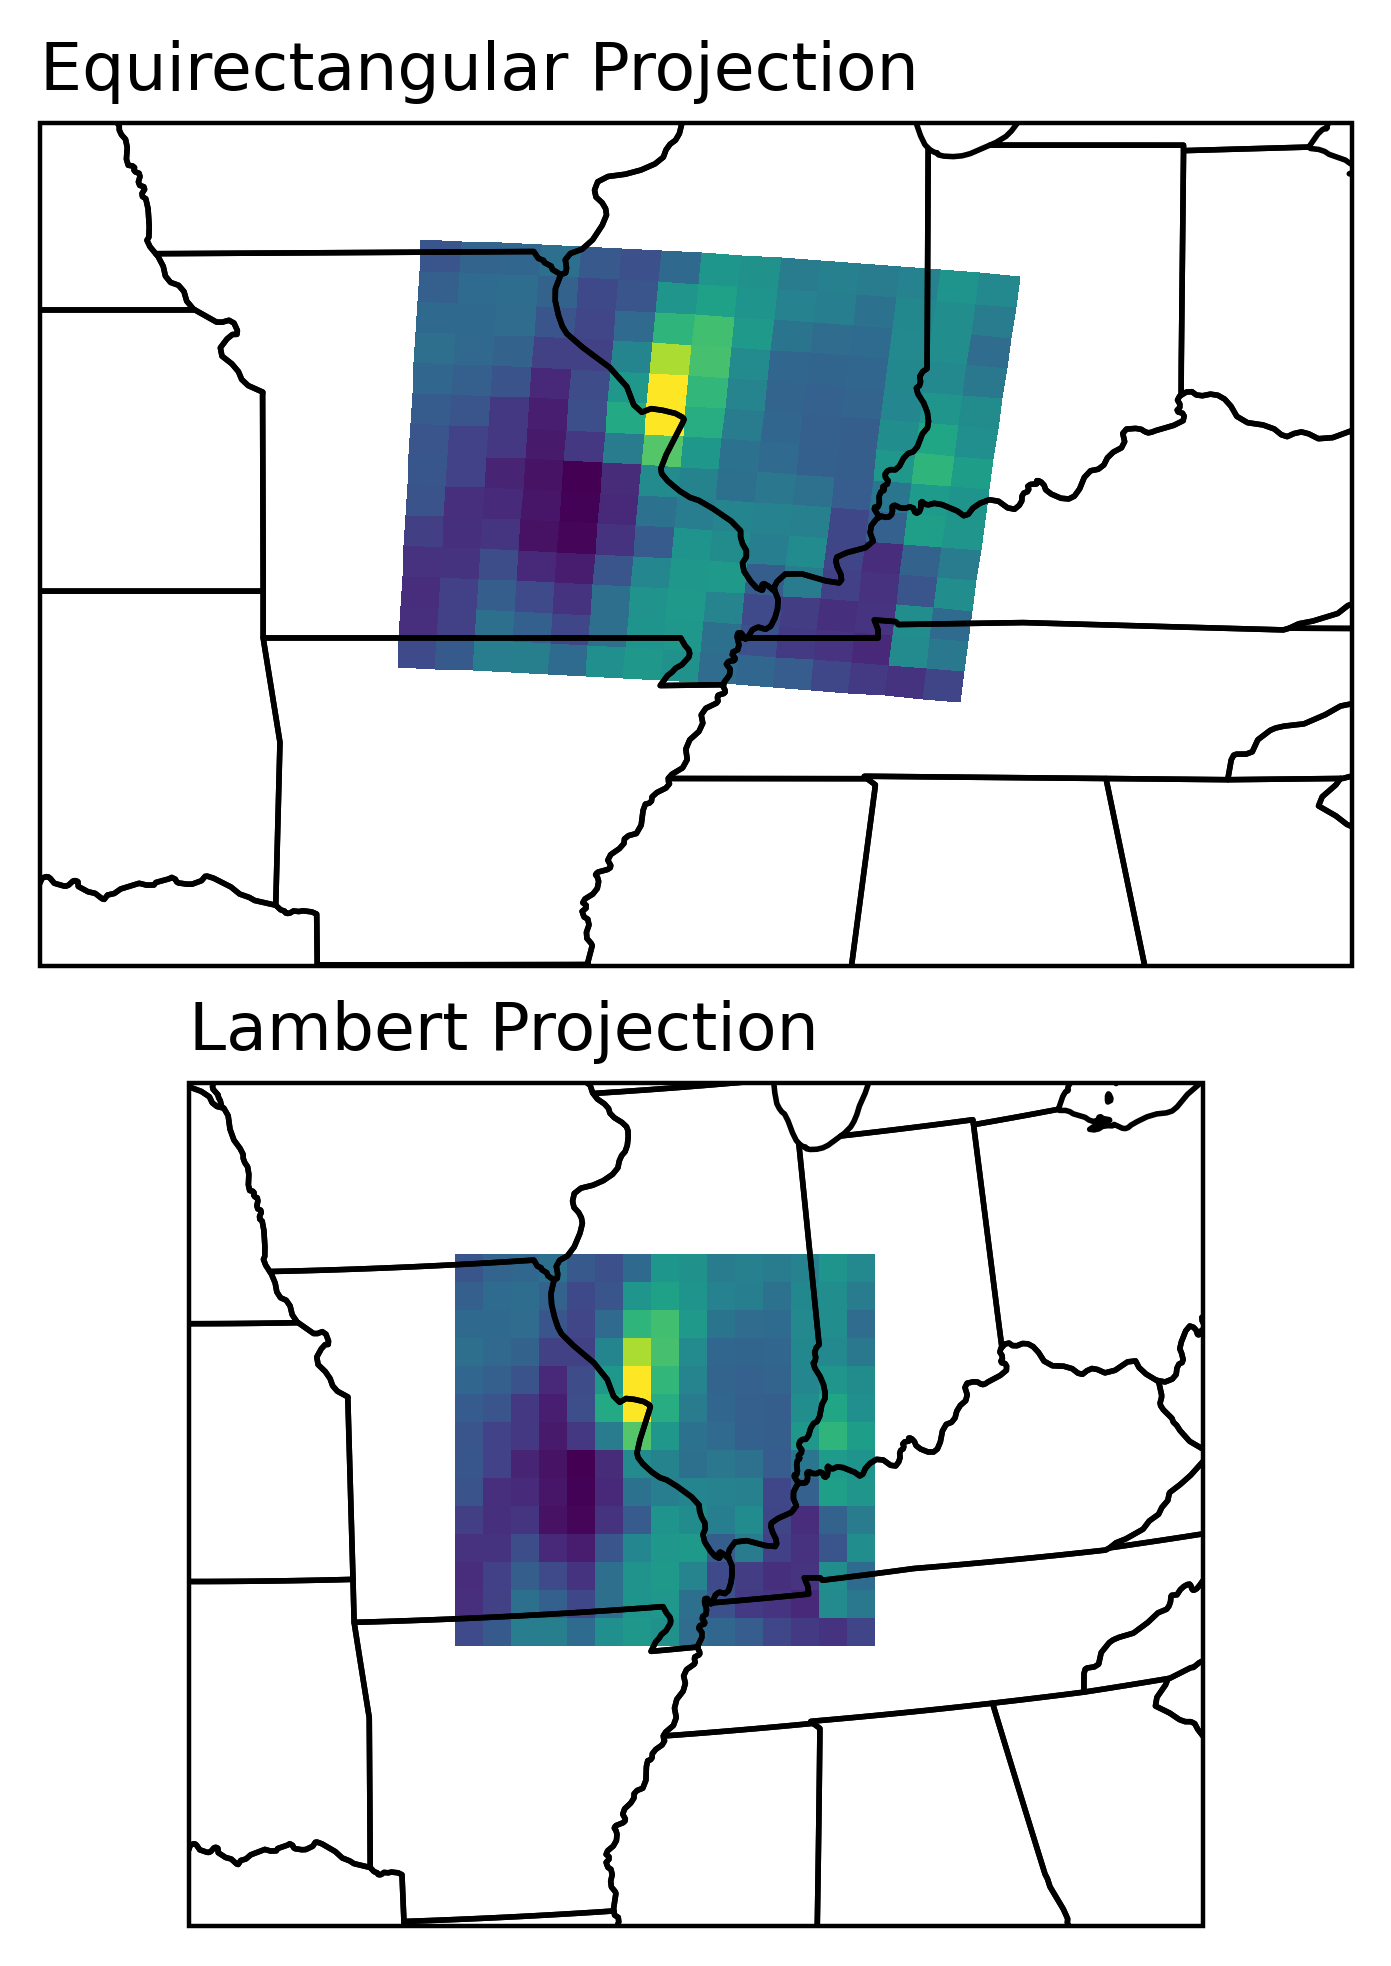

In [25]:
fig = plt.figure(dpi=400,layout='constrained')

ax1 = fig.add_subplot(211,projection=proj_i)
ax2 = fig.add_subplot(212,projection=proj_f)

ax1.set_title("Equirectangular Projection",loc='left')
ax2.set_title("Lambert Projection",loc='left')

for ax in [ax1,ax2]:

    ax.set_extent([-97,-83,33,42],crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.STATES.with_scale(scale))
    ax.pcolormesh(dset_stl.x,dset_stl.y,dset_stl['O3'].isel(time=50),transform=proj)